In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [36]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [37]:
# Save references to each table
Measurement_T = Base.classes.measurement
Station_T = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB (__-PIPELINE-__)
session = Session(engine)

In [39]:
#look at the tables as a DF for easy viewing and understanding
measurement_df = pd.read_sql(session.query(Measurement_T).limit(5).statement, engine)

station_df = pd.read_sql(session.query(Station_T).limit(5).statement, engine)

measurement_df
#station_df



,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8


# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement_T.date).order_by(Measurement_T.date.desc()).first()[0]

print(f'the most recent date is {most_recent_date}')

the most recent date is 2017-08-23


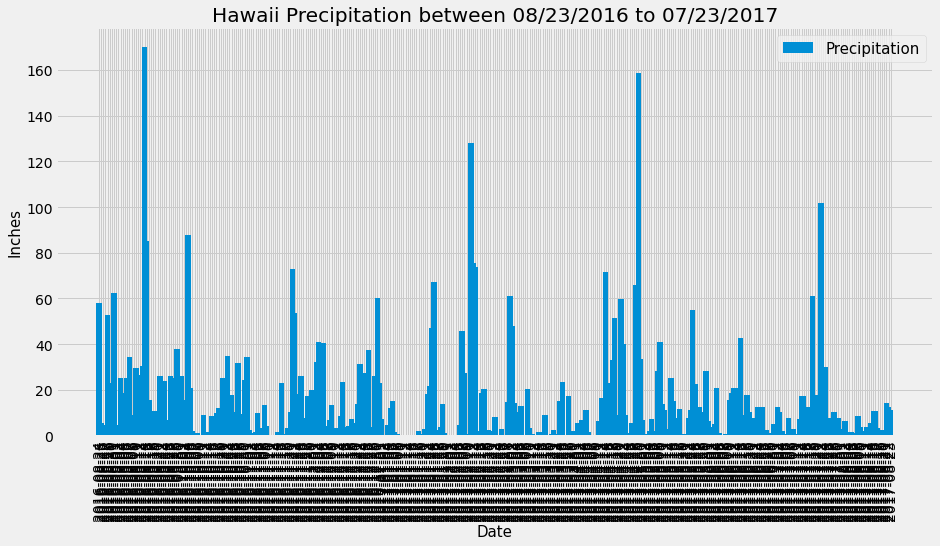

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start_date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
end_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
year_precipitation = session.query(Measurement_T.date, Measurement_T.prcp).\
    filter(Measurement_T.date > end_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
year_precipitation = pd.read_sql((year_precipitation).statement, engine)
year_precipitation = year_precipitation.set_index('date')


# Sort the dataframe by date
year_precipitation = year_precipitation.sort_values(by='date')

year_precipitation = year_precipitation.groupby('date').max()


# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=(14, 7))

plt.bar(year_precipitation.index, year_precipitation['prcp'], width = 2.5)
plt.xticks(rotation=90)
plt.title('Hawaii Precipitation between 08/23/2016 to 07/23/2017')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Inches', fontsize = 15)
plt.xticks(rotation = 90)
plt.legend(['Precipitation'], fontsize = 15)

plt.show()



In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print('summary statistics for precipitation data')
year_precipitation.describe()


summary statistics for precipitation data


,prcp
count,365.000000
mean,13.143288
std,21.062054
min,0.000000
25%,1.000000
50%,6.400000
75%,16.500000
max,170.200000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station_T).distinct(Station_T.station).count()
print(f'there are {station_count} stations in the data')

there are 9 stations in the data


c:\Users\richa\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  


In [44]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

station_active = session.query(Measurement_T.station, func.count(Measurement_T.station))\
    .group_by(Measurement_T.station)\
    .order_by(func.count(Measurement_T.station).desc())\
    .all()

# List the stations and the counts in descending order.
print(f'stations from most active to least active')
for station, count in station_active:
    print(f"{station}: {count}")

most_active_station = station_active[0][0]
print(f'most active station is {most_active_station}')


stations from most active to least active
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511
most active station is USC00519281


In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperat
max_temp = session.query(func.max(Measurement_T.tobs)).\
filter(Measurement_T.station == 'USC00519281').\
order_by(func.max(Measurement_T.tobs).desc()).all()
print(f'The maximum temperature recorded at the most active station was ' + str(max_temp[0][0]))

min_temp = session.query(func.min(Measurement_T.tobs)).\
filter(Measurement_T.station == 'USC00519281').\
order_by (func.min(Measurement_T.tobs).desc()).all()
print (f'The mininun temperature recorded at the most active station was ' + str(min_temp[0][0]))

avg_temp = session.query(func.avg(Measurement_T.tobs)).\
filter(Measurement_T.station == 'USC00519281').\
order_by(func.avg(Measurement_T.tobs).desc()).all()
print("The average temperature recorded at the most active station was "+ str(round(avg_temp[0][0],3)))


The maximum temperature recorded at the most active station was 29.4
The mininun temperature recorded at the most active station was 12.2
The average temperature recorded at the most active station was 22.036


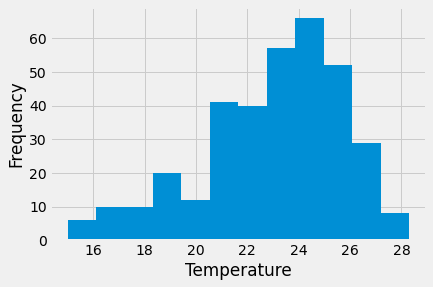

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tobs = session.query(Measurement_T.tobs).\
    filter(Measurement_T.date >= end_date).\
    filter(Measurement_T.date <= start_date).\
    filter(Measurement_T.station == most_active_station).all()

temp_array = np.ravel(station_tobs)
temp_series = pd.Series(temp_array)

# execute the query and load the data into a pandas DataFrame
temp_series.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [47]:
# Close Session
session.close()